In [1]:
import pandas as pd
from IPython.core.debugger import set_trace
import datetime
import requests
from tqdm.notebook import tqdm

In [2]:
english_names = pd.read_csv('data/articles.csv', header=None)
english_names.columns = ['Title']
english_names['Title'] = english_names['Title'].apply(lambda x : x.replace(' ', '_'))
english_names

,Title
0,.i2p
1,.tor
2,2channel
3,420chan
4,4chan
...,...
107,Yik_Yak
108,Z-Library
109,ZNC
110,ZeroNet


In [3]:
def get_qid_from_title(title, language):
    response = requests.get(f'https://{language}.wikipedia.org/w/api.php?'
                            f'action=query&prop=pageprops&titles={title}&redirects&format=json')
    try:
        r = [item for item in response.json()['query']['pages'].values()][0]
        qid = r['pageprops']['wikibase_item']
    except KeyError:
        print(f'Article {title} has no Wikidata ID')
        return None
    return qid

### Retrieve wikidata entries for each given article

In [15]:
qids = pd.DataFrame([get_qid_from_title(title, 'en') for title in tqdm(english_names.Title.values)])
qids.head()

Article Lego_Life has no Wikidata ID
Article Template:Onion_defunct has no Wikidata ID
Article Z-Library has no Wikidata ID



,0
0,Q565283
1,Q21041434
2,Q222909
3,Q96417511
4,Q238330


### English pageview data

In [5]:
def day_year_to_date(year, days):
    return datetime.datetime(year, 1, 1) + datetime.timedelta(days - 1)

def get_daily_pageviews(titles, language, years):
    data = []
    for title in tqdm(titles):
        response = requests.get(f'http://petermeissner.de:8880/article/exact/{language}/{title}')
        if response.json()['status'] == 'ok':
            article_data = response.json()['data']
            time_data = {'Article': title}
            for yearly_data in article_data:
                if yearly_data['year'] in years:  
                    view_counts = yearly_data['page_view_count'].split(',')
                    new_entries = {day_year_to_date(int(yearly_data['year']), i+1): int(c) 
                                   for i, c in enumerate(view_counts)}
                    time_data = {**time_data, 
                                 **new_entries}
        else:
            print(f"Could not retrieve data for {title}")
                
        data.append(time_data)
    
    return pd.DataFrame(data)

In [6]:
privacy_en = get_daily_pageviews(list(english_names.head(30).Title), 'en', [2011, 2012, 2013,2014])

# use article name as index
privacy_en.index = privacy_en.Article
privacy_en = privacy_en.drop(['Article'], axis=1)
privacy_en.head()

Could not retrieve data for Decentraleyes



,2012-01-01,2012-01-02,2012-01-03,2012-01-04,2012-01-05,2012-01-06,2012-01-07,2012-01-08,2012-01-09,2012-01-10,...,2011-12-22,2011-12-23,2011-12-24,2011-12-25,2011-12-26,2011-12-27,2011-12-28,2011-12-29,2011-12-30,2011-12-31
Article,,,,,,,,,,,,,,,,,,,,,
.i2p,36,28,31,29,33,54,27,24,35,41,...,37,4,0,0,16,38,39,20,48,38
.tor,0,0,0,1,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2channel,393,498,458,555,462,890,454,590,494,500,...,398,21,0,0,164,621,931,652,502,407
420chan,5,12,9,2,5,20,10,6,11,5,...,7,0,0,0,1,3,5,7,7,6
4chan,5107,6653,6964,6866,6832,12942,6163,7072,6666,7132,...,6283,368,0,0,2603,7396,6734,7481,6319,5927


### Aggregate into monthly data

In [7]:
privacy_en.columns = pd.to_datetime(privacy_en.columns)

# take monthly cumulative
monthly_en = privacy_en.resample('M', axis=1).sum()
monthly_en.head()

,2011-01-31,2011-02-28,2011-03-31,2011-04-30,2011-05-31,2011-06-30,2011-07-31,2011-08-31,2011-09-30,2011-10-31,...,2014-03-31,2014-04-30,2014-05-31,2014-06-30,2014-07-31,2014-08-31,2014-09-30,2014-10-31,2014-11-30,2014-12-31
Article,,,,,,,,,,,,,,,,,,,,,
.i2p,77,74,79,79,70,213,108,75,330,932,...,663,341,255,268,305,360,420,474,674,348
.tor,0,3,2,1,0,3,0,1,2,1,...,1,3,2,0,1,4,0,2,0,0
2channel,13495,12205,14408,11403,10981,12578,12815,12531,10237,10628,...,10748,10485,10594,8474,5037,7072,14764,9676,7576,4554
420chan,320,191,192,210,194,466,456,166,141,179,...,41,37,37,51,14,31,54,42,37,28
4chan,219734,197549,222709,190396,208034,189076,146439,146480,130159,160827,...,69623,74316,68470,59938,37590,49383,272399,97099,72794,39723


# Exploratory data analysis 

In [8]:
#Melt dataframe to use dates as entry values rather than columns
monthly_en_melt = pd.melt(monthly_en, value_name='views', var_name='date', ignore_index=False)

### Plotting the monthly total pageviews

<AxesSubplot:xlabel='date', ylabel='views'>

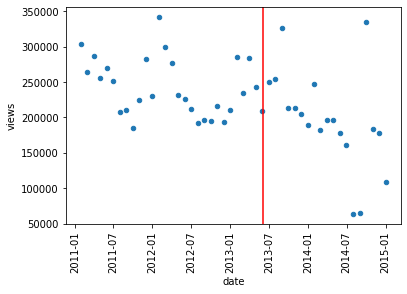

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot, dates
import datetime

reveal = datetime.datetime(2013, 6, 5) #Around june 
fig, ax = plt.subplots()
ax.axvline(reveal,c='r')
monthly_en_melt.reset_index().groupby('date').sum().reset_index().plot.scatter(x='date',y='views',ax=ax,rot=90)

### Plotting per article views (total)

<AxesSubplot:xlabel='Article'>

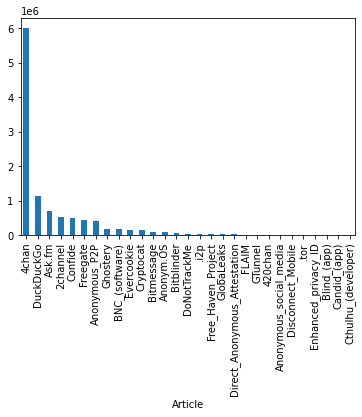

In [10]:
monthly_en_melt.reset_index().groupby('Article')['views'].sum().sort_values(ascending=False).plot.bar()

It looks like most of the traffic generated on these pages comes from the 4Chan article, which has been famous for many scandals unrelated to internet privacy, which means also probably a high variance in views. Since we can safely assume this article to not be helpful regarding the tendency of people to look for privacy-enhancing tools, we blacklist this article from our study. Just to be safe : we check the views per months per article.

### Plotting per article views (monthly)

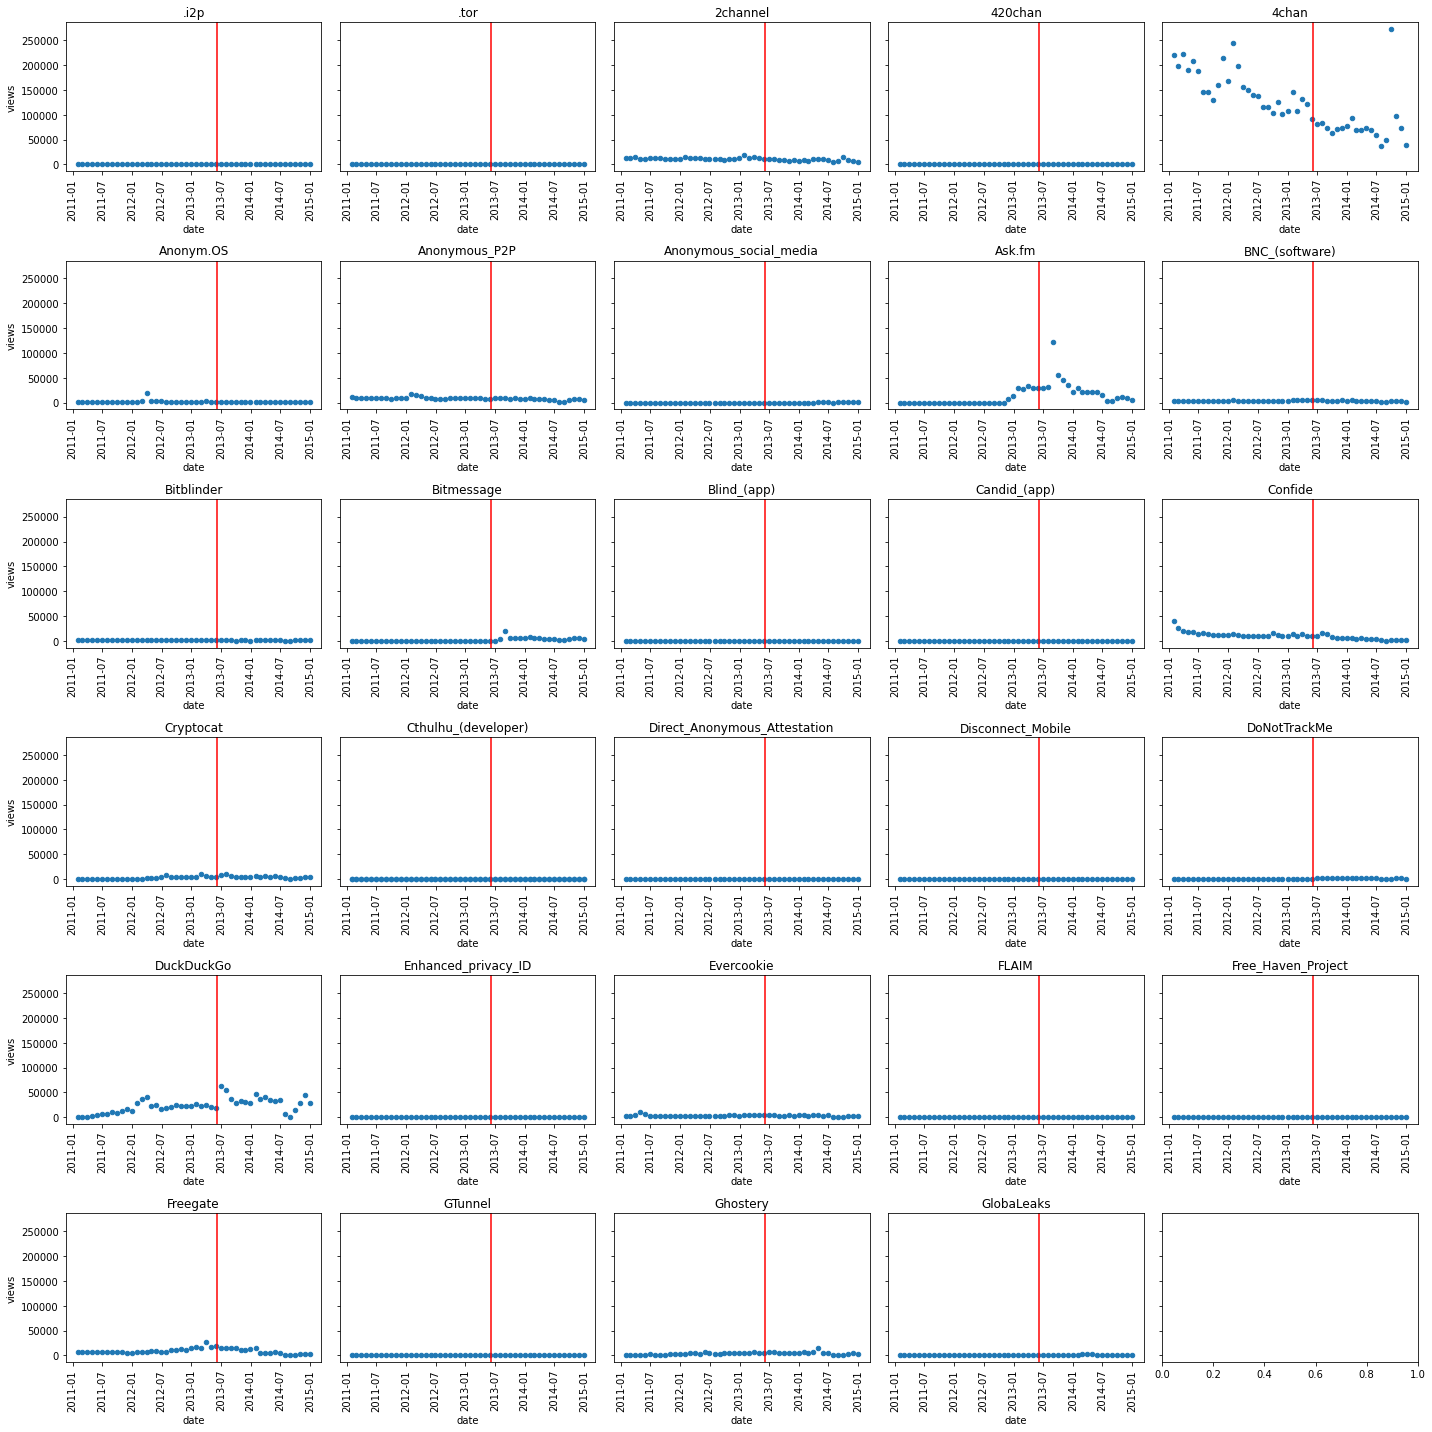

In [11]:
fig, axs = plt.subplots(6,5,figsize=(20,20),sharey=True)
for article,ax in zip(list(monthly_en_melt.index.unique()),axs.flat):
    monthly_en_melt.loc[article][['date','views']].reset_index().plot.scatter(x='date',y='views',ax=ax,rot=90)
    ax.axvline(reveal,c='r')
    ax.set_title(article)
plt.tight_layout()

Indeed, we decide to blacklist 4Chan from our articles. On another note, even at this scale, we see that there seems to be an immediate impact on the pageviews for DuckDuckGo.

### Removing 4chan from our articles

In [12]:
monthly_en_melt = monthly_en_melt.drop('4chan')

### A world without 4Chan

<AxesSubplot:xlabel='date', ylabel='views'>

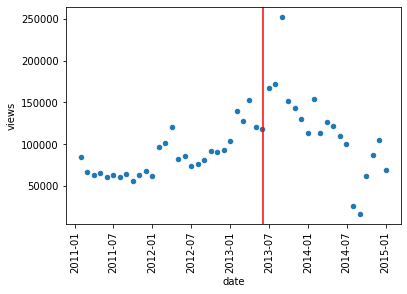

In [16]:
fig, ax = plt.subplots()
ax.axvline(reveal,c='r')
monthly_en_melt.reset_index().groupby('date').sum().reset_index().plot.scatter(x='date',y='views',ax=ax,rot=90)

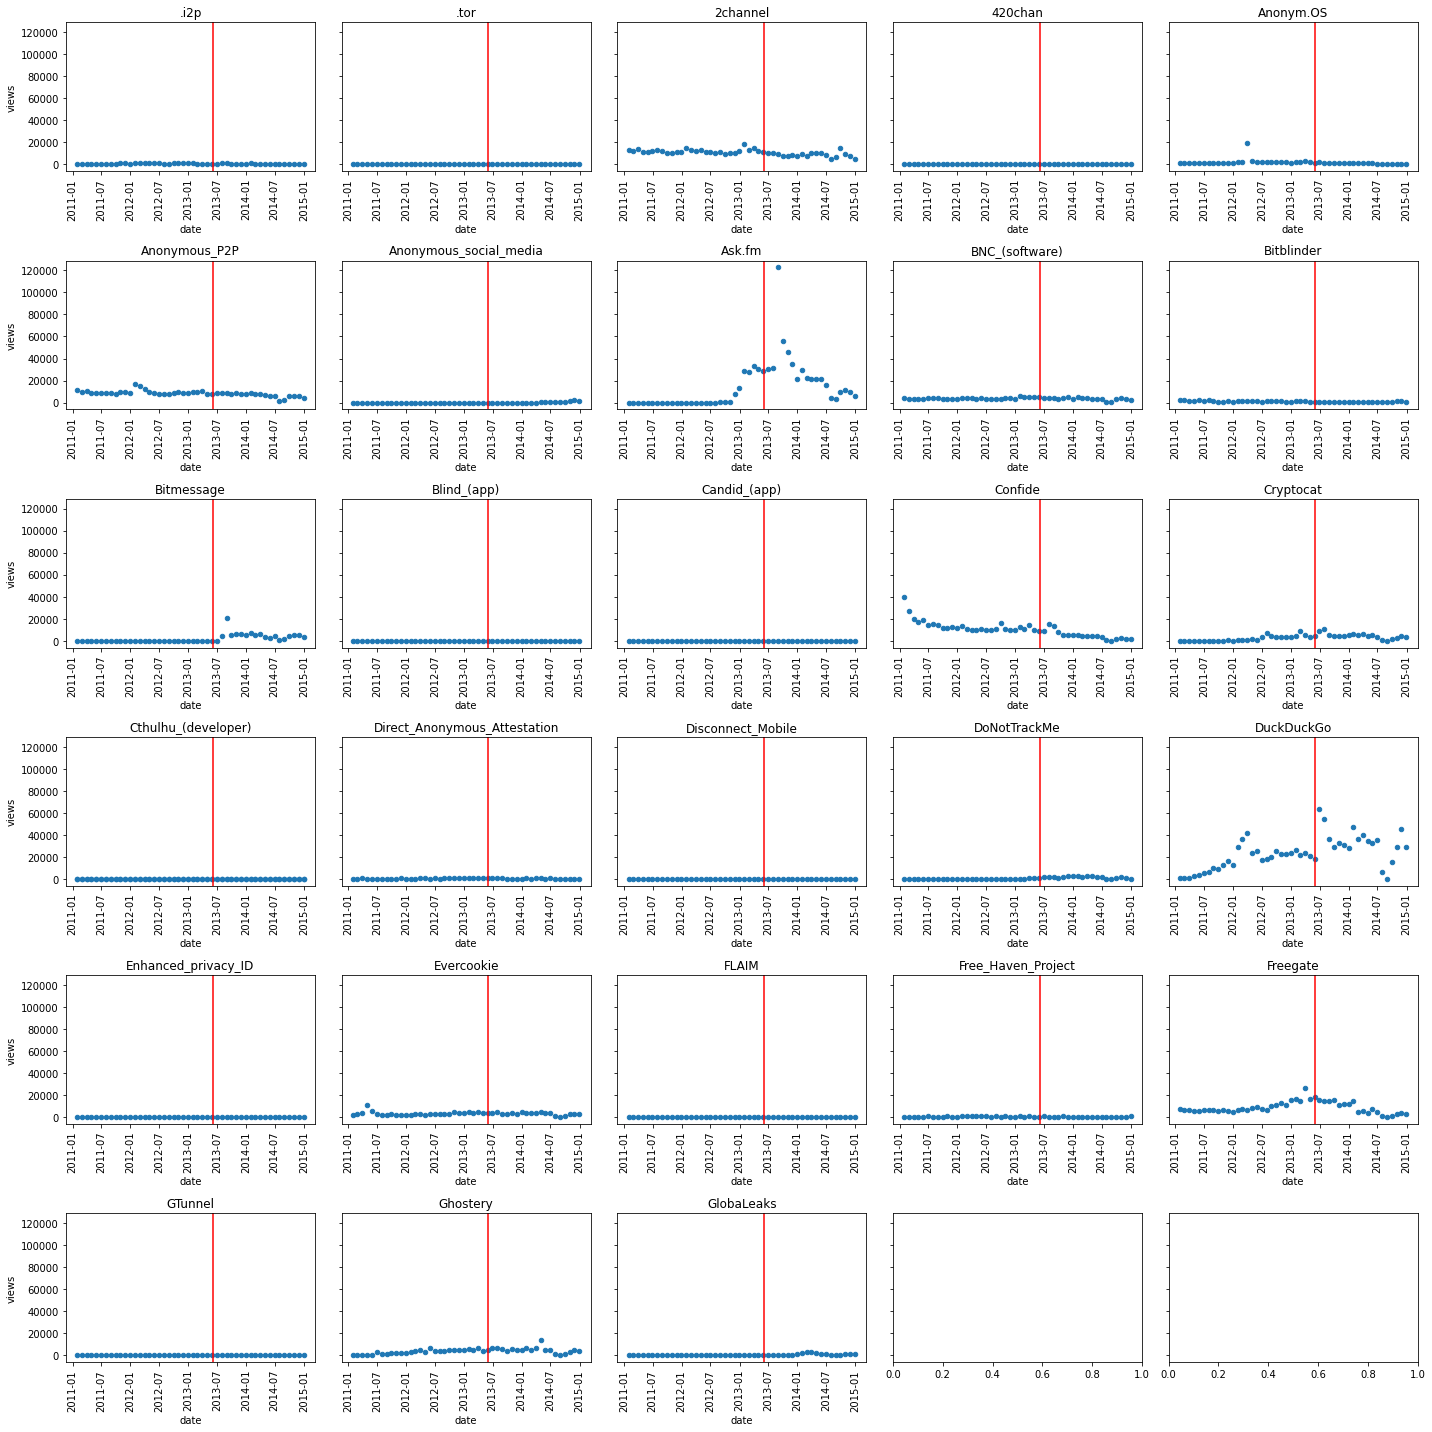

In [13]:
fig, axs = plt.subplots(6,5,figsize=(20,20),sharey=True)
for article,ax in zip(list(monthly_en_melt.index.unique()),axs.flat):
    monthly_en_melt.loc[article][['date','views']].reset_index().plot.scatter(x='date',y='views',ax=ax,rot=90)
    ax.axvline(reveal,c='r')
    ax.set_title(article)
plt.tight_layout()

<AxesSubplot:xlabel='Article'>

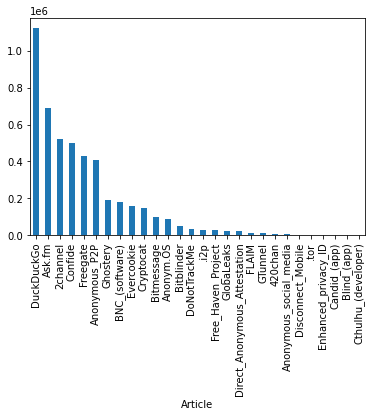

In [14]:
monthly_en_melt.reset_index().groupby('Article')['views'].sum().sort_values(ascending=False).plot.bar()